# Advanced Feature Engineering Models
## subsection of _Feature Engineering for Text Representation_

    1. Word2Vec Model
    2. Robust Word2Vec Models with Gensim
    3. Applying Word2Vec Features for Machine Learning Tasks
    4. The GloVe Model
    5. Applying GloVe Features for Machine Learning Tasks
    6. The FastText Model
    7. Applying FastText Features to Machine Learning Tasks

* traditional models:
    - pros: effective for extracting features
    - cons: model is bag of unstructures words; lose semantics, structure, sequence and context around nearby words in each text doc
* explore models that give us features that are vector representation of words, popularly known as embeddings
* raw text data: dealing with individual words that may have their own identifiers and don't capture the semantic relationship among words
    - leads to huge sparse word vectors for textual data
    - not enough data -> may get poor models or overfit
* to overcome shortcoming of BOW models, use vector space models (VSMs) in a way that we can embed work vectors in this continuous vector space based on semantic and contextual similarity
* _distributional hypothesis_ in field of distributional semantics: words that occur and are used in the same context are semantically similar to one another and have similar meanings; i.e "a word is characterized by the company it keeps"
* two main types of methods for contextual word vectors
    1. count-based methods, i.e Latent Semantic Analysis (LSA): used to calculate statistical measures of how often words occur with their neighboring words in a corpus  and then build dense word vectors for each word from these measures
    2. predictive methods, i.e neural network based language models: try to predict words from their neighboring words by looking at word sequences in a corpus; in process, it learns distributed representations giving us dense word embeddings

# Loading the Bible Corpus

In [2]:
from nltk.corpus import gutenberg
from string import punctuation
import handmade.pickle_jar as pj

bible = gutenberg.sents('bible-kjv.txt')
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, pj.normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


# Word2Vec Models
* predictive deep learning based model
* computes and generates distributed and continuous dene vector representations of words that capture contextual and semantic similarity
* unsupervised models that take in massive textual corpora, create a vocabulary of possible words, and generate dense word embeddings for each word in the vector space representing that vocabulary
* can usually specify the size of the word embedding vectors
* total number of vectors are essentially the size of the vocabulary
* makes dimensionality of dense vector space lower than the high-dimensional sparse vector space built using traditional BOW models
* two different model architectures that can be leveraged by Word2Vec to create word embedding representations
    1. The Continuous Bag of Word (CBOW) models
    2. The Skip-Gram Model

## The Continuous Bag of Words (CBOW) Models
* tries to predict the current target word (center word) based on the source context words (surrounding words)
* EX. "the quick brown fox jumps over the lazy dog"
    - can be pairs of (context_window, target_word)
    - consider context window of size 2
    - (\[quick, fox\], brown), (\[the, brown\], quick), (\[the, dog\], lazy), etc
    - the model tries to predict the target_word based on the context_window
* can give corpus w/o additional labels or info and Word2Vec models can construct dense word embeddings
* still need to leverage a supervised, classification methodology once you have corpus to get embeddings; do from within the corpus itself
* model CBOW architecture as a deep learning classification model such that we take in context words as our input X and try to predict the target word Y

## Implementing the Continuous Bag of Words (CBOW) Model

## Build the Corpus Vocabulary

In [3]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

Using TensorFlow backend.


## Build Vocabulary of Unique Words

In [4]:
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


## Build a CBOW (context, target) generator

In [6]:
import numpy as np
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1

            context_words.append(
                [words[i] for i in range(start, end)
                 if 0 <= i < sentence_length and i != index]
            )
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield(x,y)

# test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


## Build the CBOW model architecture

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


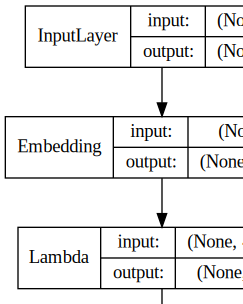

In [7]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size, )))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg'))

## Train the Model

In [8]:
# for epoch in range(1,6):
#    loss = 0
#    i = 0
#    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
#        i += 1
#        loss += cbow.train_on_batch(x, y)
#        if i % 1000000 == 0:
#            print('Processed {} (context, word) pairs'.format(i))
#    
#    print('Epoch:', epoch, '\tLoss:', loss)
#    print()

# Note: Computationally expensive; works better if trained using a GPU. Trained on AWS p2.x instance with a Tesla K80 GPU and still took close to 1.5 hours for just five epochs!

## Get Word Embeddings

In [9]:
# weights = cbow.get_weights()[0]
# weights = weights[1:]
# print(weights.shape)

# pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

In [10]:
# from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
# distance_matrix = euclidean_distances(weights)
# print(distance_matrix.shape)

# view contextually similar words
# similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses', 'famine']}

## The Skip-Gram Model
* tries to achieve the reverse of the CBOW model
* tries predicting the source context words (surrounding words) given a target word (the center word)
* EX. "the quick brown fox jumps over the lazy dog"
    - predict context \[quick, fox\] given the target word "brown", etc
* tries to predict context_window based on the target_word
* to simplify, break down (target, context_words) pairs into (target, context) pairs
* use \[(target, context), 1\] pairs as positive inputs where the 1 indicates that they are contextually relevant, and use \[(target, random), 0\] as negative input samples

## Build the Corpus Vocabulary

In [11]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


## Build a Skip-Gram \[(target, context), relevancy\] Generator

In [12]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("{:s} ({:d}), {:s} ({:d}) -> {:d}".format(
        id2word[pairs[i][0]], pairs[i][0],
        id2word[pairs[i][1]], pairs[i][1],
        labels[i]
    ))

king (13), ithrite (5419) -> 0
bible (5766), james (1154) -> 1
bible (5766), king (13) -> 1
james (1154), king (13) -> 1
james (1154), bible (5766) -> 1
king (13), bible (5766) -> 1
bible (5766), marah (4732) -> 0
king (13), james (1154) -> 1
king (13), merab (6095) -> 0
bible (5766), senuah (10225) -> 0


## Build the Skip-Gram Model Architecture

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_2_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1242500     embedding_2_input[0][0]          
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       1242500     embedding_3_input[0][0]          
____________________________________________________________________________________________

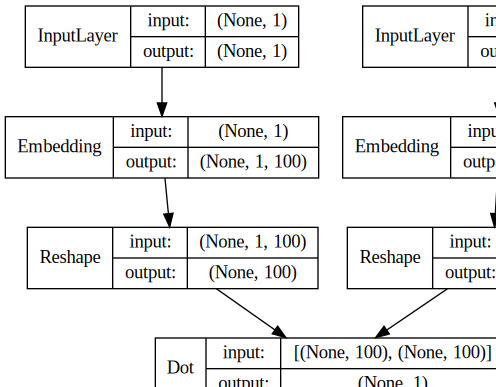

In [13]:
from keras.layers import Dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model

# build skip-gram architecture
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform', input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform', input_length=1))
context_model.add(Reshape((embed_size, )))

model_arch = Dot(axes=1)([word_model.output, context_model.output])
model_arch = Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid')(model_arch)
model = Model([word_model.input, context_model.input], model_arch)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(model.summary())

# visualize model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg'))

## Train the Model

In [14]:
# for epoch in range(1,6):
#    loss = 0
#    for i, elem in enumerate(skip_grams):
#        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
#        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
#        labels = np.array(elem[1], dtype='int32')
#        X = [pair_first_elem, pair_second_elem]
#        Y = labels
#        if i % 10000 == 0:
#            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
#        loss += model.train_on_batch(X, Y)
#    
#    print('Epoch:', epoch, 'Loss:', loss)

## Get Word Embeddings

In [15]:
#word_embed_layer = model.layers[2]
#weights = word_embed_layer.get_weights()[0][1:]

#print(weights.shape)
#pd.DataFrame(weights, index=id2word.values()).head()

#from sklearn.metrics.pairwise import euclidean_distances

#distance_matrix = euclidean_distances(weights)
#print(distance_matrix.shape)

#similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
#                 for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses', 'famine']}

#similar_words

In [16]:
# visualize word embeddings using t-SNE (t-distributed stochastic neighbor embedding)

#from sklearn.manifold import TSNE

#word = sum([[k] + v for k, v in similar_words.items()], [])
#words_ids = [word2id[w] for w in words]
#word_vectors = np.array([weights[idx] for idx in words_ids])
#print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

#tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
#np.set_printoptions(suppress=True)
#T = tsne.fit_transform(word_vectors)
#labels = words

#plt.figure(figsize=(14,8))
#plt.scatter(T[:,1], c='steelblue', edgecolors='k')
#for label, x, y in zip(labels, T[:,0], T[:, 1]):
#    plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

# Robust Word2Vec Models with Gensim
* gensim framework is robust, efficient, and scalable implementation of Word2Vec model
* workflow: tokenize our normalized corpus and then focus on the following four parameters: (1) size, (2) window, (3) min_count, (4) sample
* basic idea: provide a corpus of documents as inputs and get feature vectors as outputs
* internally: constructs a vocabulary based on the input text documents and learns vector representations for words based on various techniques; once completed, it builds a model that can be used to extract word vectors for each word in a document
* using techniques like average weighting or TF-IDF weighting, we can compute the averaged vector representation of a document using its word vectors

In [18]:
import nltk
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# set values for various parameters
feature_size = 100 # word vector dimensionality
window_context = 30 # context window size
min_word_count = 1 # minimum word count
sample = 1e-3 # downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, window=window_context, min_count=min_word_count, sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                 for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses', 'famine']}

similar_words

{'god': ['worldly', 'lord', 'reasonable', 'godly', 'established'],
 'jesus': ['peter', 'messias', 'apostles', 'james', 'neverthless'],
 'noah': ['shem', 'japheth', 'ham', 'enosh', 'kenan'],
 'egypt': ['pharaoh', 'egyptians', 'bondage', 'rid', 'lice'],
 'john': ['james', 'baptist', 'baptism', 'galilee', 'peter'],
 'gospel': ['christ', 'sufferings', 'godly', 'hope', 'persecutions'],
 'moses': ['congregation', 'ordinance', 'naashon', 'elisheba', 'aaron'],
 'famine': ['pestilence', 'peril', 'overtaketh', 'deaths', 'sword']}

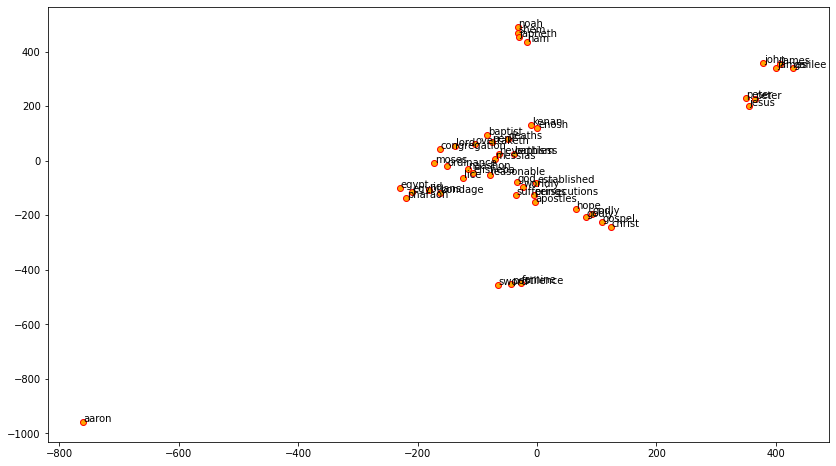

In [20]:
# visualize words of interest
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14,8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

# Applying Word2Vec Features for Machine Learning Tasks

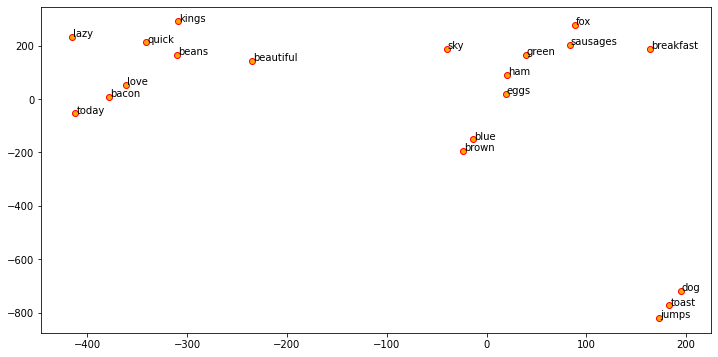

In [22]:
# build word2vec model
import handmade.pickle_jar as pj

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in pj.norm_corpus]

# set values for various parameters
feature_size = 10 # word vector dimensionality
window_context = 10 # context window size
min_word_count = 1 # minimum word count
sample = 1e-3

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, window=window_context, min_count=min_word_count, sample=sample, iter=100)

# visualize embeddings
from sklearn.manifold import TSNE
words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words
plt.figure(figsize=(12,6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

In [23]:
w2v_model.wv['sky']

array([-0.0022837 , -0.02443176, -0.00761188, -0.03327611, -0.0402256 ,
       -0.00789876,  0.04964563,  0.0501953 ,  0.0313855 , -0.03655402],
      dtype=float32)

## Strategy for Getting Document Embeddings

In [25]:
import pandas as pd
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features, ), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
        
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        
        return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model, num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,-0.002284,-0.024432,-0.007612,-0.033276,-0.040226,-0.007899,0.049646,0.050195,0.031385,-0.036554
1,0.002455,0.000110,0.020499,-0.029191,-0.016598,-0.034947,0.033303,0.024498,0.004143,0.020613
2,-0.026916,0.010070,-0.022051,-0.006870,-0.022100,-0.011560,0.007478,0.046957,-0.031367,-0.002863
3,-0.036803,0.019018,-0.041254,-0.001134,-0.019662,0.037380,0.041809,0.025011,0.046149,0.025705
4,0.002455,0.000110,0.020499,-0.029191,-0.016598,-0.034947,0.033303,0.024498,0.004143,0.020613
5,0.043116,0.005005,0.007061,-0.026189,0.027113,0.013339,-0.045782,-0.007047,0.005121,-0.047661
6,-0.002284,-0.024432,-0.007612,-0.033276,-0.040226,-0.007899,0.049646,0.050195,0.031385,-0.036554
7,-0.001591,-0.037167,0.006220,0.022778,0.026896,-0.044003,-0.040429,-0.034473,0.043826,-0.009203


In [27]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([pj.corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,3
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, e...",food,0
4,"I love green eggs, ham, sausages, and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beaut...,weather,3
7,The dog is lazy but the brown fox is quick!,animals,4


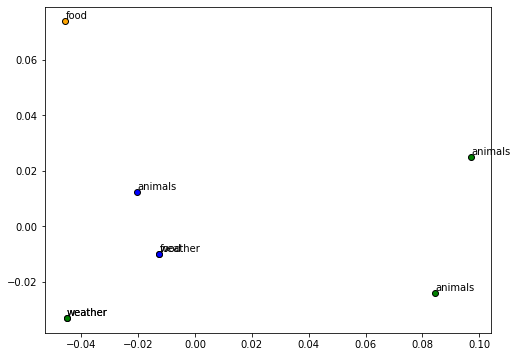

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(pj.corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0  else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0,0), textcoords='offset points')

# The GloVe Model

# Applying GloVe Features for Machine Learning Tasks

In [3]:
import spacy

nlp = spacy.load('en_vectors_web_lg')
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

OSError: [E050] Can't find model 'en_vectors_web_lg'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

In [ ]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

# Applying FastText Features to Machine Learning Tasks

In [ ]:
#from gensim.models.fasttext import FastText

#wpt = nltk.WordPunctTokenizer()
#tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# set values for various parameters
#feature_size = 100 # word vector dimensionality
#window_context = 50 # context window size
#min_word_count = 5 # minimum word count
#sample = 1e-3 # downsample setting for frequent words

# sg decides whether to use the skip-gram model (1) or CBOW (0)
#ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, min_count=min_word_count, sample=sample, sg=1, iter=50)

# view similar words based on gensim's FastText model
#similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)] for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses', 'famine']}

#similar_words

In [ ]:
# print(ft_model.wv.similarity(w1='god', w2='satan'))
# print(ft_model.wv.similarity(w1='god', w2='jesus'))

#st1 = "god jesus satan john"
#print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))
#str2 = "john peter james judas"
#print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))